# Reconstruction Demo script

1. for horizontal line in stack X
   1. reconstruct
2. z-stack?

Sources: 

Volume viewer: https://www.datacamp.com/tutorial/matplotlib-3d-volumetric-data


In [1]:
from skimage.transform import iradon
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
PATH_TO_IMAGE =  'data/2022-10-10_1433_testrecon_result.tif'
im = io.imread(PATH_TO_IMAGE)
print(im.shape)

(400, 365, 273)


In [3]:
theta = np.linspace(0, 360, np.shape(im)[0])
theta

array([  0.        ,   0.90225564,   1.80451128,   2.70676692,
         3.60902256,   4.5112782 ,   5.41353383,   6.31578947,
         7.21804511,   8.12030075,   9.02255639,   9.92481203,
        10.82706767,  11.72932331,  12.63157895,  13.53383459,
        14.43609023,  15.33834586,  16.2406015 ,  17.14285714,
        18.04511278,  18.94736842,  19.84962406,  20.7518797 ,
        21.65413534,  22.55639098,  23.45864662,  24.36090226,
        25.26315789,  26.16541353,  27.06766917,  27.96992481,
        28.87218045,  29.77443609,  30.67669173,  31.57894737,
        32.48120301,  33.38345865,  34.28571429,  35.18796992,
        36.09022556,  36.9924812 ,  37.89473684,  38.79699248,
        39.69924812,  40.60150376,  41.5037594 ,  42.40601504,
        43.30827068,  44.21052632,  45.11278195,  46.01503759,
        46.91729323,  47.81954887,  48.72180451,  49.62406015,
        50.52631579,  51.42857143,  52.33082707,  53.23308271,
        54.13533835,  55.03759398,  55.93984962,  56.84

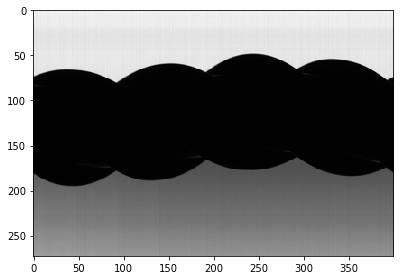

In [4]:
# Convert image stack to sinograms
# Want shape (length, width, angles)
sinogram = np.moveaxis(im, 0, -1)
io.imshow(sinogram[0])

In [5]:
reconstruction_fbp = np.zeros((im.shape[1], im.shape[2], im.shape[2]))
for i in tqdm(range(im.shape[1])):
    reconstruction_fbp[i] = iradon(sinogram[i], theta=theta, filter_name='ramp')
    


100%|█████████████████████████████████████████| 365/365 [02:20<00:00,  2.59it/s]


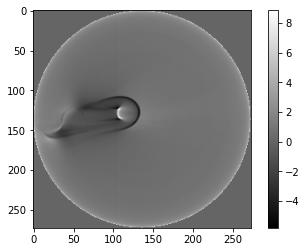

In [6]:
plt.imshow(reconstruction_fbp[280], cmap='gray')
plt.colorbar()

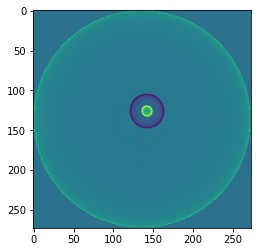

In [7]:
# This method is a bit slow

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])
    ax.set_title(ax.index)

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    ax.set_title(ax.index)

multi_slice_viewer(reconstruction_fbp)

In [11]:
%matplotlib notebook

<IPython.core.display.Javascript object>


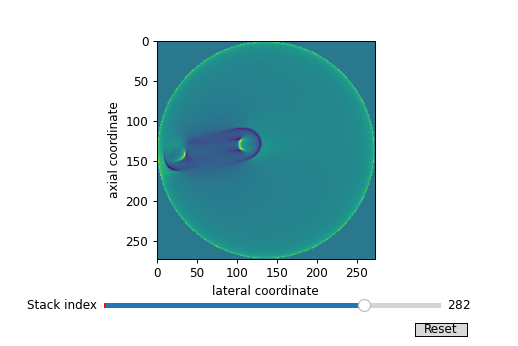

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(index):
    return reconstruction_fbp[index]

max_index = im.shape[1]
allowed_indices = np.arange(0, max_index)

# Define initial parameters
init_index = 0


# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
display = ax.imshow(f(init_index))
ax.set_xlabel('lateral coordinate')
ax.set_ylabel('axial coordinate')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(bottom=0.25)

# # Make a horizontal slider to control the frequency.
ax_index = fig.add_axes([0.2, 0.1, 0.65, 0.03])
index_slider = Slider(
    ax=ax_index,
    label='Stack index',
    valmin=0,
    valmax= max_index,
    valstep = allowed_indices,
    valinit=init_index,
)

# # Make a vertically oriented slider to control the amplitude
# axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
# amp_slider = Slider(
#     ax=axamp,
#     label="Amplitude",
#     valmin=0,
#     valmax=10,
#     valinit=init_amplitude,
#     orientation="vertical"
# )


# The function to be called anytime a slider's value changes
def update(val):
    display = ax.imshow(f(index_slider.val))
    # ax.(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
index_slider.on_changed(update)
# amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

In [7]:
import cv2
from tifffile import imread


# load images
image1 = im[0]
image2 = im[200]

# compute difference
difference = cv2.subtract(image1, image2)

# color the mask red
# Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
Conv_hsv_Gray = difference
ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
difference[mask != 255] = [0, 0, 255]

# add the red mask to the images to make the differences obvious
image1[mask != 255] = [0, 0, 255]
image2[mask != 255] = [0, 0, 255]

# store images
cv2.imwrite('diffOverImage1.png', image1)
cv2.imwrite('diffOverImage2.png', image1)
cv2.imwrite('diff.png', difference)

ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 4782 output values where the mask is true